# End-to-End Machine Learning Project: 

## Forecasting California's Housing Prices in the the 90s

**Original Code and Guide**:  
Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. *O'Reilly*. 

**Date**:
February 2025

**Author of the Present Script**:  
Yvan Richard  
yvan.richard2004@gmail.com

___

To proceed with this project, we will follow the following steps: 
1. Frame the problem and understand the big picture 
2. Load the data
3. Exploratory Data Analysis (EDA) & Cleaning
5. Models exploration and shortlist of the best models
6. Fine-tuning 
7. Final Solution

## 1. Framing the Problem 

### 1.1 General Settings

The target of this project is to forecast the median price in different blocks (aggregate of houses containing btw. $600$ and $3000$ people) in California. Currently, this estimation is conducted manually by analysts conducting surveys in the field. However, the accuracy of their predictions is not great and that is why it was judged benefitial to build an ML model. 

Therefore, taking into account the context and the data we will access, we face a: 
+ supervised learning problem 
+ regression problem 
+ univariate regression problem 
+ with plain batch learning since the dataset is relatively small

### 1.2 Selection of a Performance Measures

In this regression problem, we will rely on a widely used loss function, namely the **Root Mean Squarred Error** (RMSE). The root mean squarred error will *measure* the distance of our predictions from the true values. Our goal will be to minimize the RMSE. The RMSE is given by:
$$
RMSE(X, \hat{y}) = \sqrt{\frac{1}{n} \sum_{i = 1}^{n} (\hat{y}^{(i)} - y^{(i)})^2}
$$

Where: 
+ $\hat{y}^{(i)} = h(x^{(i)})$ is the value of our prediction. ($h$ stands for hypothesis).
+ $y^{(i)}$ is the true value. 
+ $x^{(i)}$ are the features of the $i$-th observation. 

Finally, note that the RMSE is the euclidean norm or the $\mathcal{l}_2$ norm of a vector $\vec{v} = \hat{y} - y$

## 2. Loading the Data

To load the dataset, we try to generalize the process by writing a function with the libraries `pathlib`, `tarfile`, and `urllib.request`:

In [1]:
# loading the required packages
from pathlib import Path # A module for handling file system paths in an object-oriented way.
import pandas as pd
import tarfile # A module for working with .tar and .tar.gz archive files. It allows extracting files from such archives.
import urllib.request

# defining the function to download the data
def load_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file(): # If the file doesn’t exist, the code will proceed to download and extract it.
        Path("datasets").mkdir(parents=True, exist_ok=True) # This line creates the datasets directory if it doesn’t already exist.
        url = "https://github.com/ageron/data/raw/main/housing.tgz" 
        urllib.request.urlretrieve(url, tarball_path) # This line downloads the tarball from the URL and saves it to the datasets directory.
        with tarfile.open(tarball_path) as housing_tarball: # This line extracts the housing.csv file from the tarball.
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv")) # This line loads the data using pandas and returns the DataFrame.

Now that we have coded our function, we can simply store the dataset into an object (a dataframe), in other words, assign it to a variable:

In [2]:
df_houses = load_data() 

# displaying the first rows of the data
df_houses.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In this first step, it is important to notice that each row, each **observation** represents a district / block. To inspect the data structure further, we can use the `info()` command: 

## 3. First EDA & Test Set Implementation

### 3.1 General Structure

In this section, we try to understand how our data are structured and what wil

In [3]:
df_houses.info()
print(f"\n# We have n = {len(df_houses)} observations in the dataset.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

# We have n = 20640 observations in the dataset.


In total, we have 10 features: 
+ `longitude`
+ `latitude`
+ `housing_median_age`
+ `total_rooms`
+ `total_bedrooms`
+ `population`
+ `households`
+ `median_income`
+ `median_house_value`
+ `ocean_proximity`

Furthermore, we are very lucky here since we only have one categorical variable `ocean_proximity` and all of the features have no `NA` values except for the feature `total_bedroom`. In reality, the datasets are not going to be that clean. 

### 3.2 Exploration of the categorical variable

First, we can inspect what are all the different categories and how many of each we have: 

In [4]:
df_houses["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Since we cannot exploit directly for our regression task this feature, we will in the near future convert these to integers using **dummy encoding**.

### 3.3 Exploration of the Numerical Variables

Now, we will visualize and understand how the different features are distributed:

In [5]:
# using the describe method to get a summary of the numerical attributes
df_houses.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

Another effective way to visualize this, is to use an histogram: 

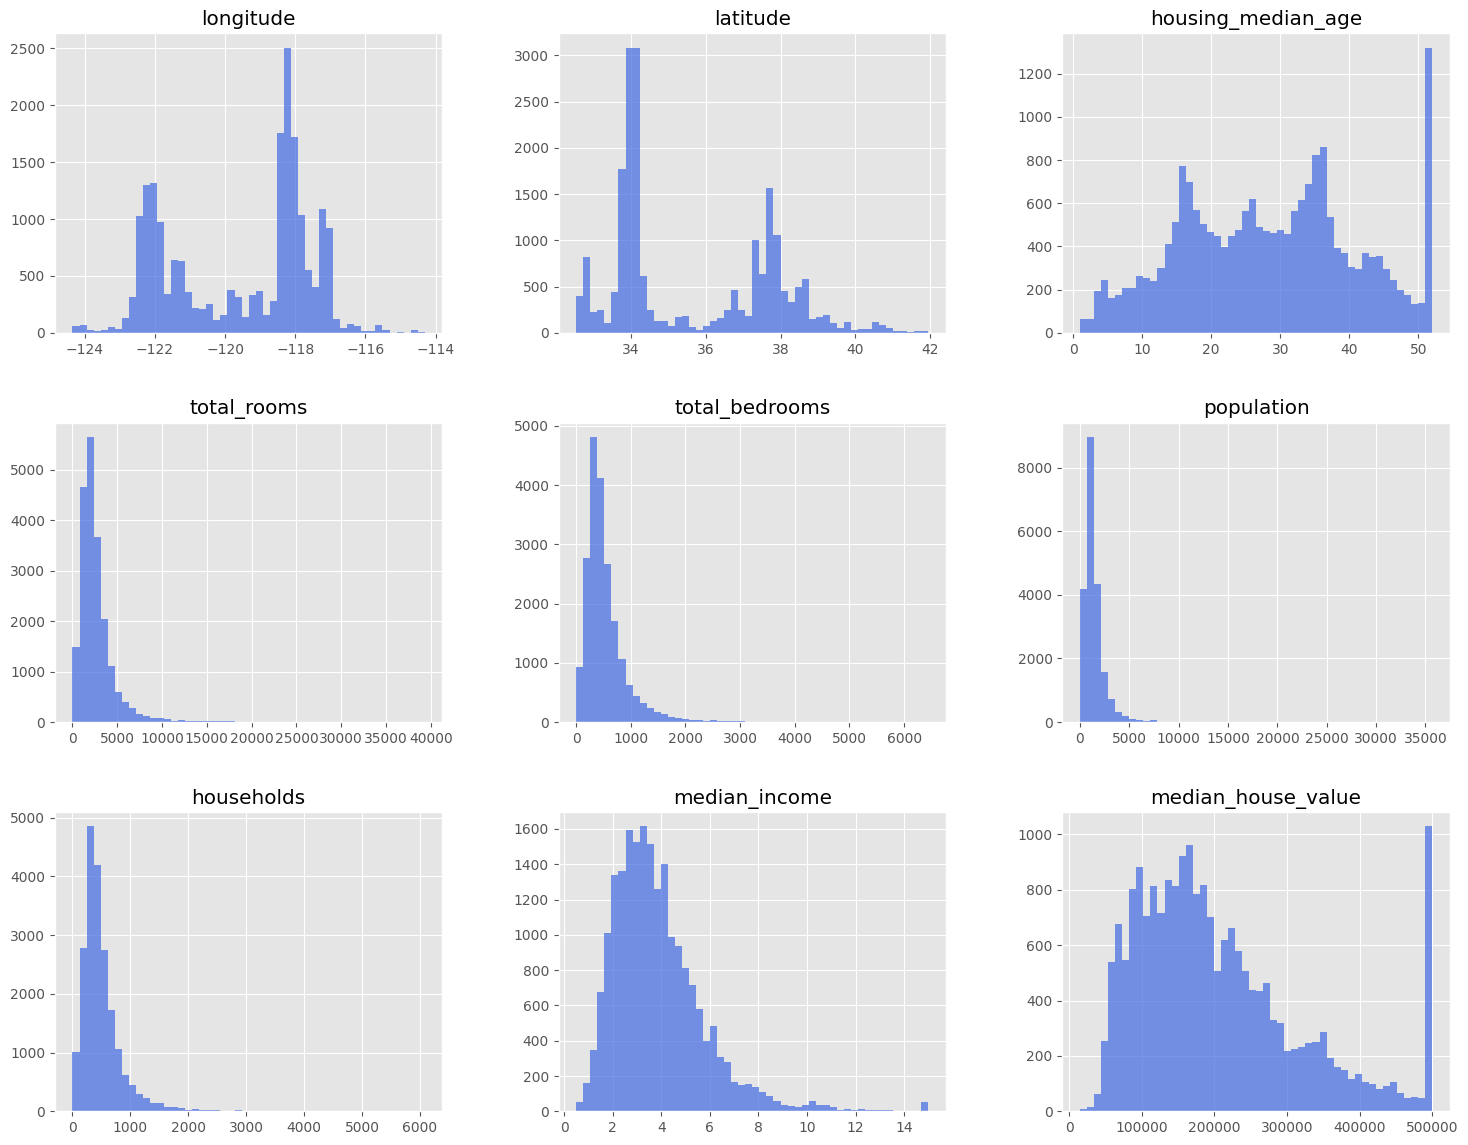

In [6]:
from matplotlib import pyplot as plt
plt.style.use('ggplot') 

# Here we simply plot the histograms of all numerical attributes
df_houses.hist(bins=50, figsize=(18,14), color='royalblue', alpha=0.7)

plt.show()

+ First, we notice that the median annual income has been scaled and capped between $0.5$ and $15$ where $1 = 10,000 \$$.
+ The data are also more skewed towards the right, we will take care of it later (standardize).
+ We also have to be careful about the fact that the `housing_median_aged` and the target `median_house_value` were capped. We should be careful about this and potentially exclude the value above this in the future otherwise our model will loose in precision...

Now that we have a better command of the structure, distribution and content of our dataset, we create a test set that we will set aside to prevent any data leakage. 

### 3.4 Test Set

One way to go for splitting our dataset is to use the function `train_test_split()` from the `scikit_learn` package. It is really short to code (in that case, note that we use the 80% training - 20% test rule): 

In [7]:
from sklearn.model_selection import train_test_split

# splitting the data into training and testing sets
train_set, test_set = train_test_split(df_houses, test_size=0.2, random_state=42)

However, when using this approach, the function `train_test_split()` will select purely randomly (since we have fixed the random state the selection is the same when running the code again) *indices* and then split the dataset into two distinct parts. The problem here intervenes because of our relativey small number of observations. When proceeding as such, we might indeed introduce a **sampling bias**, i.e. the data we have in our `train_set` are not representative of the whole dataset. To prevent this from altering our results, we have recourse to a technique named **stratified sampling**. 

**Stratified Sampling Definition**: 
> Stratified sampling is a probabilistic sampling method used in scientific research to ensure that specific subgroups (strata) within a population are adequately represented in a sample. This method involves dividing 
> the entire population into distinct strata based on shared characteristics or attributes (e.g., age, income level, education), and then drawing a proportional or equal random sample from each stratum.

**Solution for the Case at Hand**:  

In our situation, we will suppose that the `median_income` is strongly correlated to the `median_house_value` (we will check this assumption as an illustration), therefore, we will create an additional variable named `income_category` to help us create a more representative test set. Just before that, let us explore our assumption: 

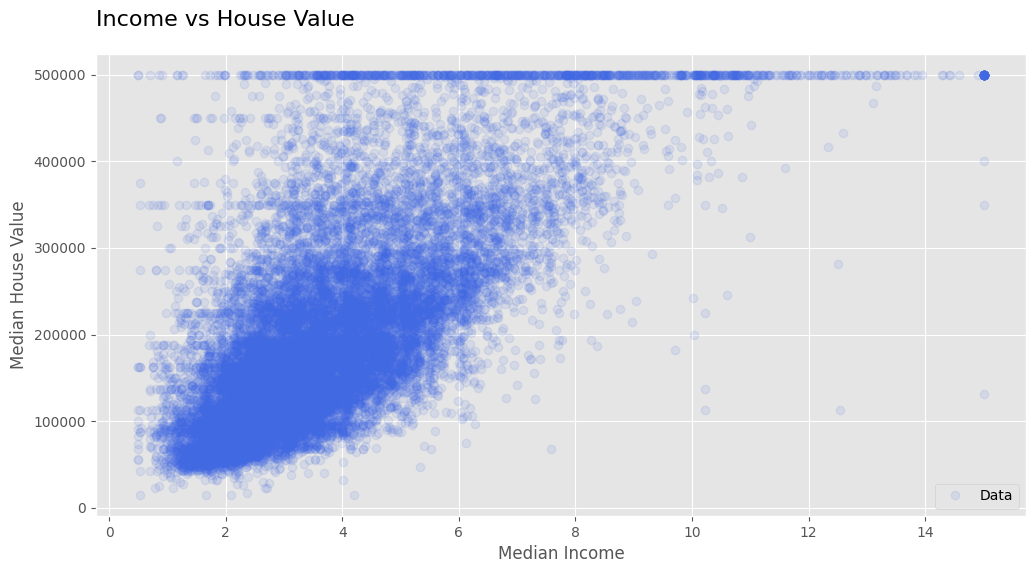

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

# plotting the income against the housing median value
ax.plot(df_houses["median_income"], df_houses["median_house_value"], 'o', color='royalblue', alpha=0.1, label='Data')
ax.set_xlabel("Median Income")
ax.set_ylabel("Median House Value")
ax.set_title("Income vs House Value", fontsize=16, loc='left', pad=20)
plt.legend()
plt.show()

Furthermore, we can confirm this visual intuition by computing the sample correlations: 

In [9]:
corr = df_houses.drop(columns=["ocean_proximity"]).corr()
corrs = pd.DataFrame(corr["median_house_value"].sort_values(ascending=False)).rename(columns={"median_house_value": "Correlation to House Value"})
corrs

Correlation to House Value
median_house_value                    1.000000
median_income                         0.688075
total_rooms                           0.134153
housing_median_age                    0.105623
households                            0.065843
total_bedrooms                        0.049686
population                           -0.024650
longitude                            -0.045967
latitude                             -0.144160

**Building the `income_cat` variable with `pd.cut()`:**

In [10]:
help(pd.cut)

Help on function cut in module pandas.core.reshape.tile:

cut(x, bins, right: 'bool' = True, labels=None, retbins: 'bool' = False, precision: 'int' = 3, include_lowest: 'bool' = False, duplicates: 'str' = 'raise', ordered: 'bool' = True)
    Bin values into discrete intervals.

    Use `cut` when you need to segment and sort data values into bins. This
    function is also useful for going from a continuous variable to a
    categorical variable. For example, `cut` could convert ages to groups of
    age ranges. Supports binning into an equal number of bins, or a
    pre-specified array of bins.

    Parameters
    ----------
    x : array-like
        The input array to be binned. Must be 1-dimensional.
    bins : int, sequence of scalars, or IntervalIndex
        The criteria to bin by.

        * int : Defines the number of equal-width bins in the range of `x`. The
          range of `x` is extended by .1% on each side to include the minimum
          and maximum values of `x`.
    

In [11]:
import numpy as np
df_houses["income_cat"] = pd.cut(df_houses["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

# inspect the new dataset: 
df_houses.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

  income_cat  
0          5  
1          5  
2          5  
3          4  
4          3

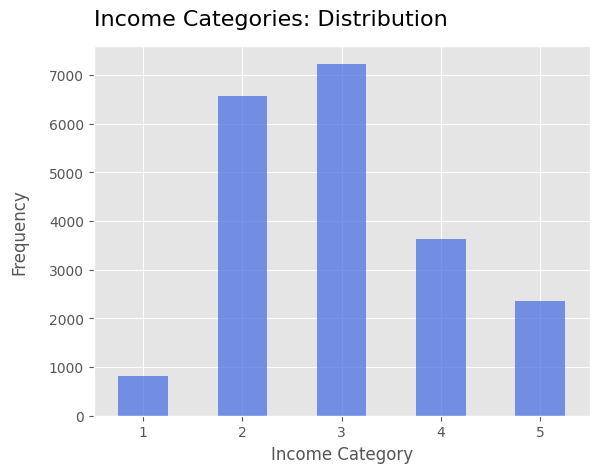

In [12]:
# plotting the income categories
df_houses["income_cat"].value_counts().sort_index().plot.bar(color='royalblue', alpha=0.7, rot=0)
plt.title("Income Categories: Distribution", fontsize=16, loc='left', pad=15)
plt.xlabel("Income Category")
plt.ylabel("Frequency", labelpad=15)
plt.show()

Now, since the function `train_test_split()` we used before is very effective, we can pass our new variable `income_cat` as a new argument: 

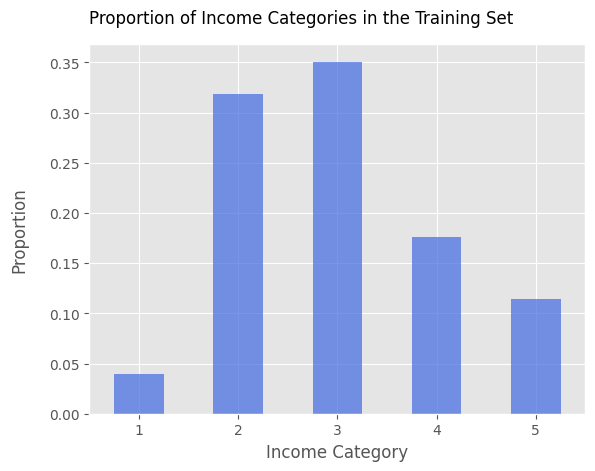

In [13]:
strat_train_set, strat_test_set = train_test_split(df_houses, test_size=0.2, random_state=42, stratify=df_houses["income_cat"])

# checking the income category proportions in the stratified training set
(strat_train_set["income_cat"].value_counts() / len(strat_train_set)).sort_index().plot.bar(color='royalblue', alpha=0.7, rot=0)
plt.title("Proportion of Income Categories in the Training Set", fontsize=12, loc='left', pad=15)
plt.xlabel("Income Category")
plt.ylabel("Proportion", labelpad=15)
plt.show()

The final step of this section is very simple, it simply consists in dropping the variable `income_cat` that we do not need anymore:

In [14]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True) # axis=1 means we are dropping a column 
    # and inplace=True means we are modifying the DataFrame directly.

strat_train_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  median_house_value  \
13096      1576.0      1034.0         2.0987            458300.0   
14973       666.0       357.0         6.0876            483800.0   
3785        562.0       203.0         2.4330            101700.0   
14689      1845.0       780.0         2.2618             96100.0   
20507      1912.0      1172.0         3.5292            361800.0   

      ocean_proximity  
13096        NEAR BAY  
14973       <1H OCEAN  
3785           INLAND  
14689          INLAND  
20507      NEAR OCEAN

## 4. EDA

To conduct our EDA, we will first use nake a copy of our `strat_train_set` to be sure that we do not modify the original:

In [15]:
df_eda = strat_train_set.copy()

### 4.1 Visualizing Geographical Data

Since the dataset incorporates geo data (longitude and latitude) of the different districts, we can easily visualize them by plotting against each other: 

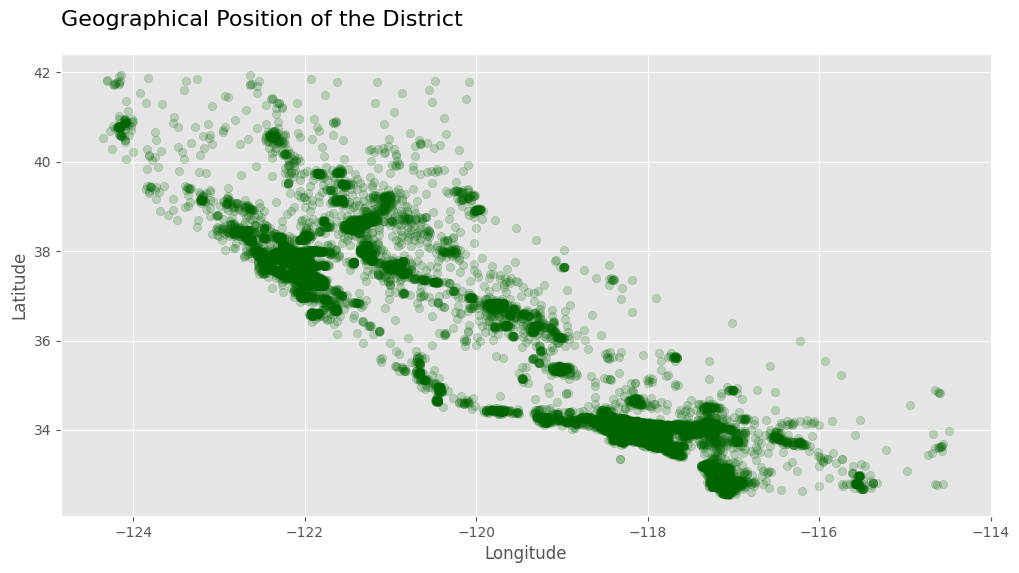

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

# plotting the geographical data
ax.scatter(df_eda["longitude"], df_eda["latitude"], alpha=0.2, color='darkgreen')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Geographical Position of the District", fontsize=16, loc='left', pad=20)
plt.show()


We can also make a cooler visualization with a basemap using the libraries `contextily` and `geopandas`: 

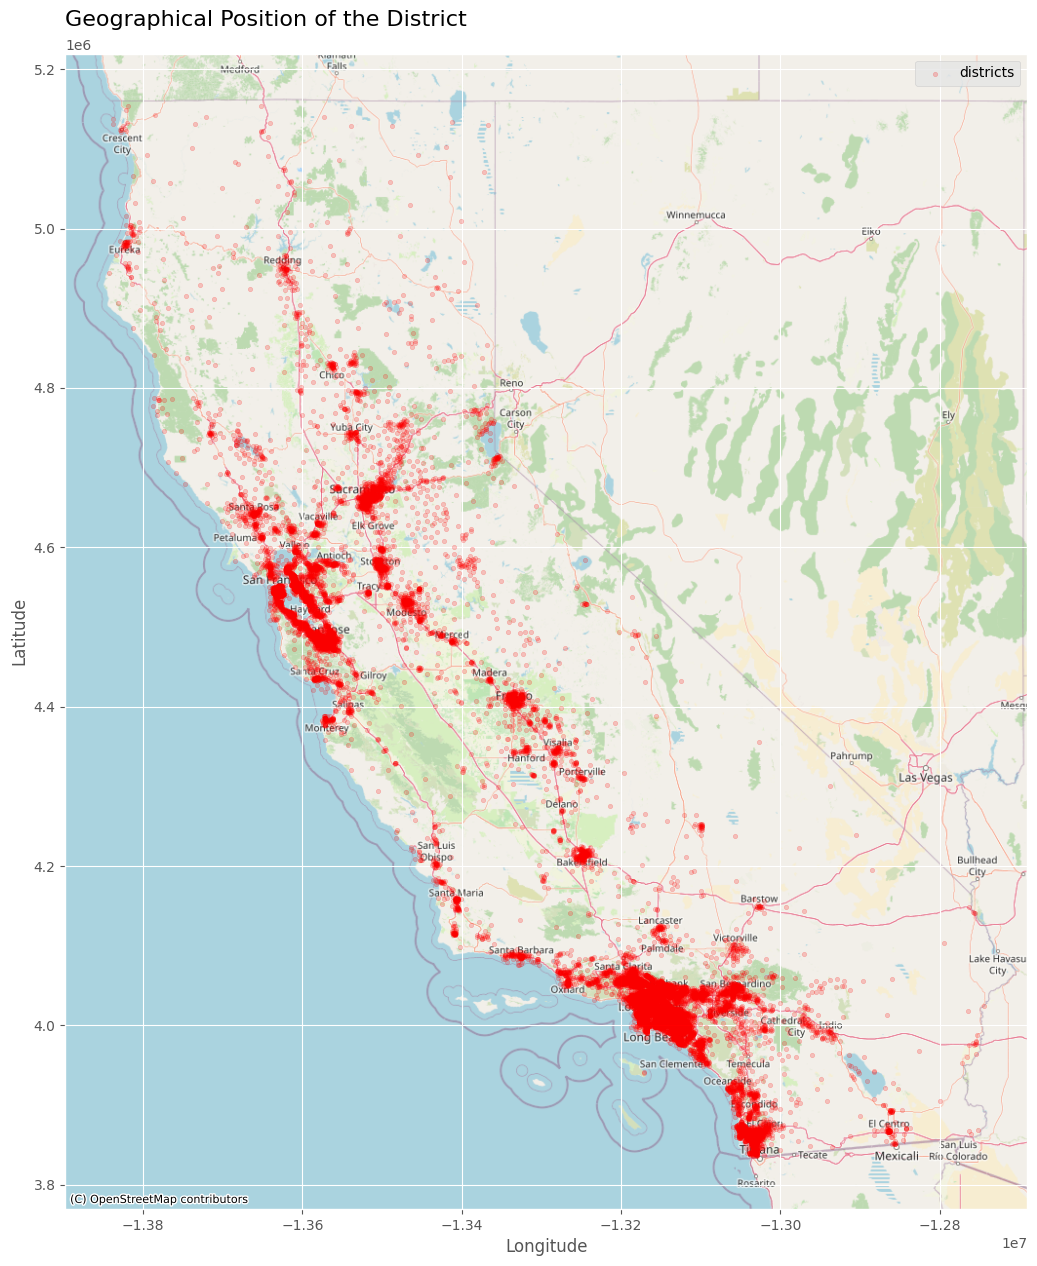

In [17]:
import contextily as ctx # A package that allows you to easily add basemaps to your plots.
import geopandas as gpd # A package that extends the popular pandas library to allow spatial operations on geometric types.
import pandas as pd

# Convert the DataFrame to a GeoDataFrame using GeoPandas
gdf = gpd.GeoDataFrame(
    df_eda, 
    geometry=gpd.points_from_xy(df_eda["longitude"], df_eda["latitude"]),
    crs="EPSG:4326"  # WGS 84, crs="EPSG:4326": Sets the coordinate reference system (CRS) of the data to WGS84, the standard for latitude and longitude coordinates.
)

# Reproject to Web Mercator 
gdf = gdf.to_crs(epsg=3857) # EPSG 3857 is the Web Mercator projection. It is the standard for flat web maps.

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(ax=ax, alpha=0.2, color='red', markersize=10, label="districts")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=1)

# Customize the axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Geographical Position of the District", fontsize=16, loc='left', pad=20)
plt.legend()

plt.show()

Now, we are going to add other dimensions to our plot, namely the `population` size and the `median_house_value` per district:

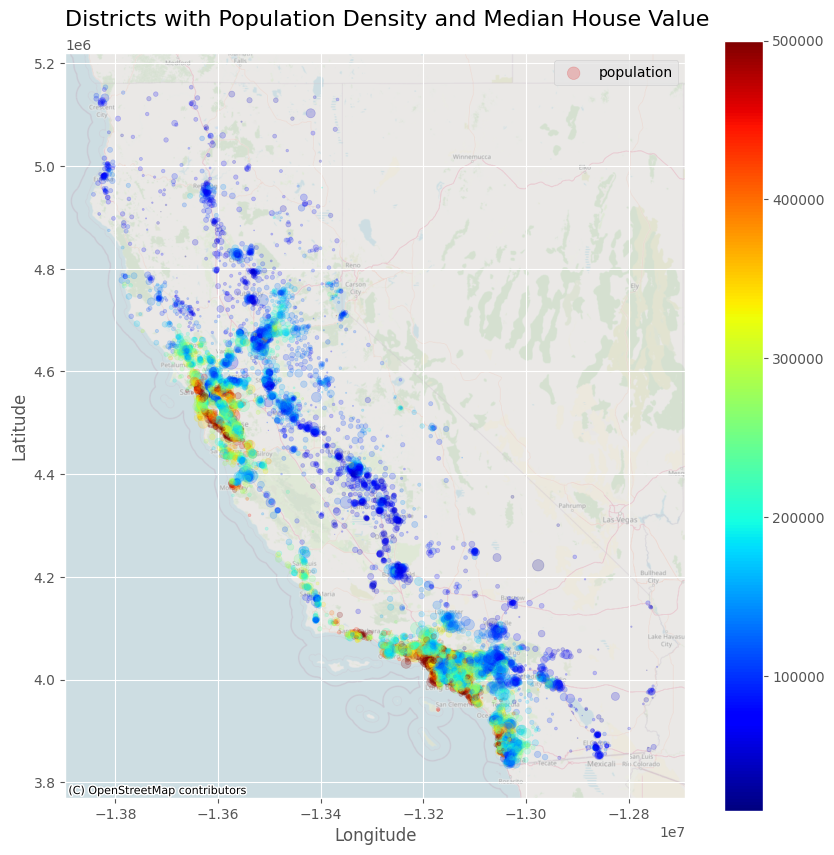

In [18]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_eda, 
    geometry=gpd.points_from_xy(df_eda["longitude"], df_eda["latitude"]),
    crs="EPSG:4326"
)

# Reproject to Web Mercator
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Dynamically set the markersize based on population density
gdf.plot(
    ax=ax, 
    alpha=0.2, 
    column="median_house_value", # Use median_house_price for color
    cmap="jet",  # Set the color map to "jet"
    markersize=gdf["population"] / 100,  # Adjust size for population density
    label="population",  # Add a label
    legend=True# Show the legend
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.4)

# Customize the axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Districts with Population Density and Median House Value", fontsize=16, loc='left', pad=20)
ax.legend()

plt.savefig("districts.png", dpi = 1000)
plt.show()

### 4.2 Scatter Matrix or Correlation Matrix

The `pandas.plotting` library equips us with a useful tool that allows to plot how the different numerical features are correlated with each other. Since we have many of them, we will only use some fetaures that seem promising. To identify these, we can proceed as follows: 

In [19]:
from pandas.plotting import scatter_matrix

In [20]:
corrs = df_eda.drop(columns=["ocean_proximity"]).corr()
print(corrs["median_house_value"].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64


We will use the first four ones as meaningful attributes: 

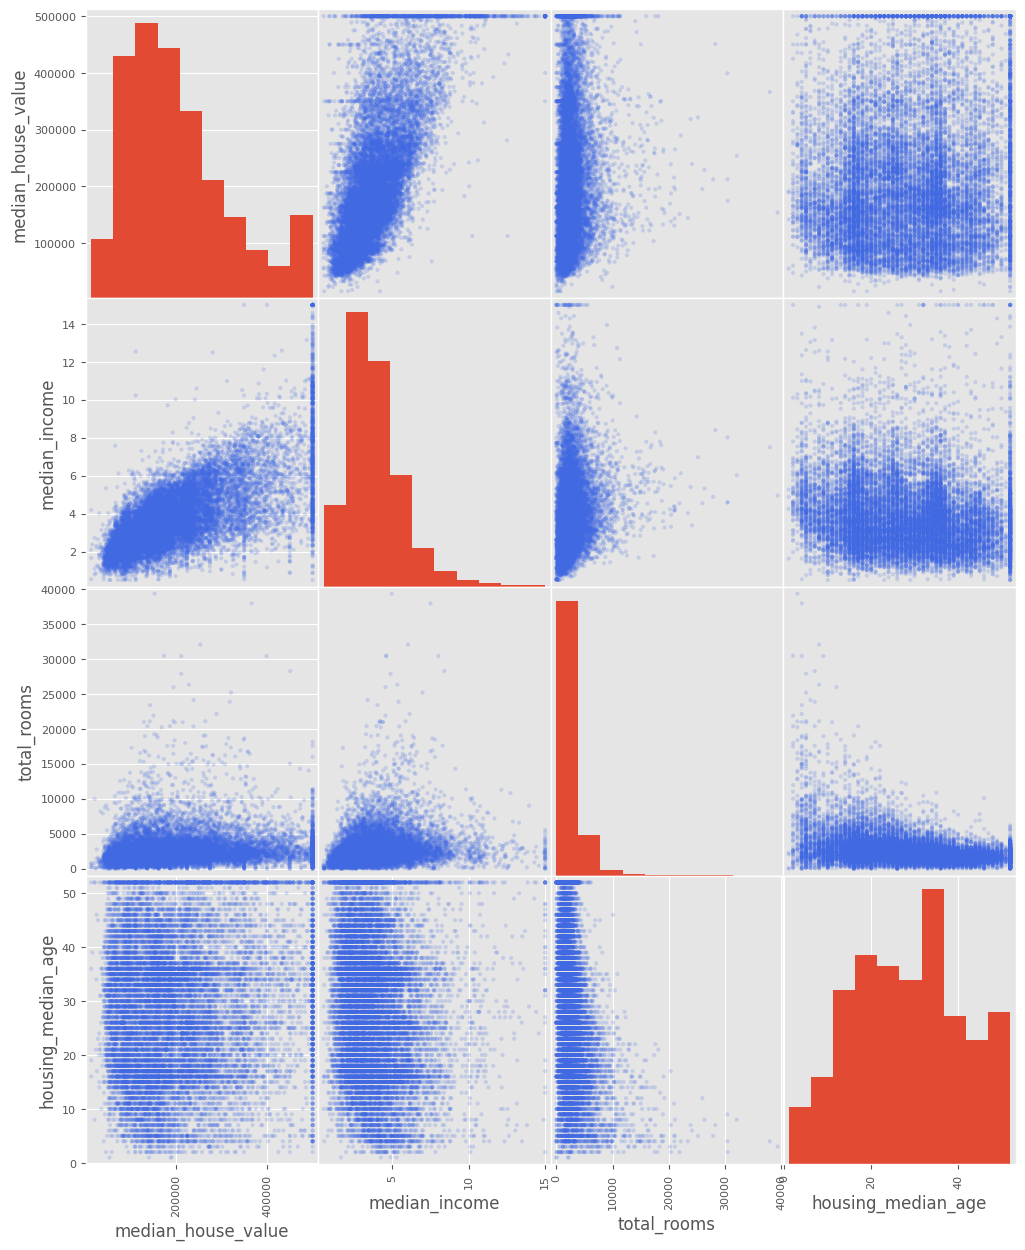

In [21]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(df_eda[attributes], figsize=(12, 15), color='royalblue', alpha=0.2)

plt.show()

With this visualization, we can confirm that the most promising feature, i.e. the feature with the highest predictive power, is the median income. And if we pause and ponder a few seconds we realize that thsis makes absolute sense. On average, rich people buy expensive houses. The only potential quack we observe is the "lines" we observe at $450,000$ and $350,000$. To prevent our model from learning from these data quirks, we might have to remove them.

### 4.3 A Glimpse of Features Engineering 

The final steps of this section is not directly part of EDA but is nonetheless closely related to it. It consists in building ratios / **interaction terms** between the features to create more coherent features or simply capture non-linear pattern in the data. The two new features we are going to create are these ones:

+ `rooms_per_house` $=$ `total_rooms` $/$ `households`
+ `bedrooms_ratio` $=$ `total_bedrooms` $/$ `total_rooms`

In [22]:
df_eda["rooms_per_house"] = df_eda["total_rooms"] / df_eda["households"]
df_eda["bedrooms_ratio"] = df_eda["total_bedrooms"] / df_eda["total_rooms"]

# inspect the new dataset
display(df_eda.head())

corrs = df_eda.drop(columns=["ocean_proximity"]).corr()
corrs["median_house_value"].sort_values(ascending=False)


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  median_house_value  \
13096      1576.0      1034.0         2.0987            458300.0   
14973       666.0       357.0         6.0876            483800.0   
3785        562.0       203.0         2.4330            101700.0   
14689      1845.0       780.0         2.2618             96100.0   
20507      1912.0      1172.0         3.5292            361800.0   

      ocean_proximity  rooms_per_house  bedrooms_ratio  
13096        NEAR BAY         3.211799        0.335742  
14973       <1H OCEAN         5.504202        0.180153  
3785           INLAND         5.334975        0.200369  
14689          INLAND         5.351282        0.203881  
20507      NEAR OCEAN         3.725256        0.277371

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

We observe that the interaction terms we created have a stronger correlation with the target than most of our original features. 

## 5. Preprocessing Data for the Models

In this section, we will build function to preprocess our dataset. This way, we will be able to reuse these **pipelines** when handling new projects and datatset. 

### 5.1 Clean the Data

In [23]:
# first, we isolate the features and the target variable
X = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

The first issue we face is relative to the feature `total_bedrooms`: 

In [24]:
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income ocean_proximity  
13096      1576.0      1034.0         2.0987        NEAR BAY  
14973       666.0       357.0         6.0876       <1H OCEAN  
3785        562.0       203.0         2.4330          INLAND  
14689      1845.0       780.0         2.2618          INLAND  
20507      1912.0      1172.0         3.5292      NEAR OCEAN

#### Handling Missing Values

We see here that we onyl have missing observation for the `total_bedrooms` feature. In data science, we can handle missing values in many different way. The simpliest strategy in the case at hand would be to exclude this feature from our dataset (complete case analysis). However, since we only have a small percentage of `NA` values, it wouldn'z be the wisest appraoch and surely harm the final quality of our predictions. The strategy we will select in this case is named the **imputation** method (i.e. we interpolate the missing values). Here, we will simply replace the `NA`values by the median value of the variable `total_bedrooms`:

**WARNING**: we will compute the value on our train set and use this exact same value to interpolate the test set. Otherwise, it would be a form of data leakage (i.e. our model access unforseen informations).

In [25]:
# percentage of missing values
n = int(X["total_bedrooms"].isna().sum())
print(f"Percentage of missing values: {n/len(X)*100:.2f}%")

Percentage of missing values: 1.02%


1. **Hard Code**

We solve our problem only with basic libraries: 

In [26]:
# we compute the median:
med_tb = X["total_bedrooms"].median()
print(f"The median of total bedrooms is {med_tb}")

The median of total bedrooms is 434.0


In [27]:
# we replace the missing values with the median using boolean indexing
mask = X["total_bedrooms"].isna()
X.loc[mask, "total_bedrooms"] = med_tb

# check if the missing values have been replaced
X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


2. **`Scikit-Learn` and the `SimpleImputer` Function**

Keep in mind that the scikit-learn library also offer model-based imputation functions (`KNNImputer` or `ÌterativeImputer`) that can potentially yield better results.

In [28]:
# first, we isolate the features and the target variable
X = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

In [29]:
X_o = X["ocean_proximity"]
X_o

13096      NEAR BAY
14973     <1H OCEAN
3785         INLAND
14689        INLAND
20507    NEAR OCEAN
            ...    
14207     <1H OCEAN
13105        INLAND
19301    NEAR OCEAN
19121     <1H OCEAN
19888    NEAR OCEAN
Name: ocean_proximity, Length: 16512, dtype: object

In [30]:
from sklearn.impute import SimpleImputer

# we create an instance of the SimpleImputer class
imputer = SimpleImputer(strategy="median") # we set the strategy to median but it can be mean, most_frequent, constant

# we subset the numerical attributes
X_num = X.drop("ocean_proximity", axis=1)

# we fit the imputer to the training data
imputer.fit(X_num)

# we check the statistics_ attribute of the imputer
imputer.statistics_

# we transform the training set
X_num_tr = imputer.transform(X_num)

# we convert the NumPy array back to a DataFrame
X_tr = pd.DataFrame(X_num_tr, columns=X_num.columns, index=X_num.index)

# merge the dataframes
X = pd.concat([X_tr, X_o], axis=1)
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income ocean_proximity  
13096      1576.0      1034.0         2.0987        NEAR BAY  
14973       666.0       357.0         6.0876       <1H OCEAN  
3785        562.0       203.0         2.4330          INLAND  
14689      1845.0       780.0         2.2618          INLAND  
20507      1912.0      1172.0         3.5292      NEAR OCEAN

### 5.2 Handling Text and Categorical Attributes

In our dataset, we have to handle the categorical feature `ocean_proximity`:

In [31]:
display(X.head())
X.info()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income ocean_proximity  
13096      1576.0      1034.0         2.0987        NEAR BAY  
14973       666.0       357.0         6.0876       <1H OCEAN  
3785        562.0       203.0         2.4330          INLAND  
14689      1845.0       780.0         2.2618          INLAND  
20507      1912.0      1172.0         3.5292      NEAR OCEAN

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


To proceed we will use a technique named **one hot code encoding** (it is called that way because it will replace the strings with a boolean array consisting of $0$ and $1$ where the one is the *hot*, true feature):

In [32]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False) # drop='first' to avoid multicollinearity by dropping the first category, sparse_output=False to return a 2D array
encoded_features = encoder.fit_transform(X[['ocean_proximity']]) # Fit and transform the data

# Add encoded features back to the DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['ocean_proximity']), index=X.index)
X_encoded = pd.concat([X.drop(columns=['ocean_proximity']), encoded_df], axis=1)

X_encoded.head(n=6)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   
1286     -121.31     37.96                52.0       1829.0           301.0   

       population  households  median_income  ocean_proximity_INLAND  \
13096      1576.0      1034.0         2.0987                     0.0   
14973       666.0       357.0         6.0876                     0.0   
3785        562.0       203.0         2.4330                     1.0   
14689      1845.0       780.0         2.2618                     1.0   
20507      1912.0      1172.0         3.5292                     0.0   
1286        694.0       319.0         3.3466                     1.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
13096                     0.0                       1.0   
14973                     0.0                       0.0   
3785                      0.0                       0.0   
14689                     0.0                       0.0   
20507                     0.0                       0.0   
1286                      0.0                       0.0   

       ocean_proximity_NEAR OCEAN  
13096                         0.0  
14973                         0.0  
3785                          0.0  
14689                         0.0  
20507                         1.0  
1286                          0.0

### 5.3 Features Scaling and Transformation

#### MinMax Scaling

MinMax Scaling is a feature scaling technique that transforms numerical data into a fixed range, typically $[0,1]$ or $[-1,1]$, while preserving the relationships between data points. It ensures that all features have the same scale, which is particularly useful for machine learning algorithms that rely on distance-based metrics (e.g., K-Nearest Neighbors, Support Vector Machines, Neural Networks).

Formula:
$$X^{\prime} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}$$

where:
+ $X$ is the original value,
+ $X_{\min}$ is the minimum value of the feature,
+ $X_{\max}$ is the maximum value of the feature,
+ $X^{\prime}$ is the scaled value.

If you want to scale it to a custom range $[a, b]$, the formula becomes:

$$X^{\prime} = a + \frac{(X - X_{\min}) (b - a)}{X_{\max} - X_{\min}}$$


While it is very easy to code this from scratch, `scikit-learn` directly provides us with this function: 

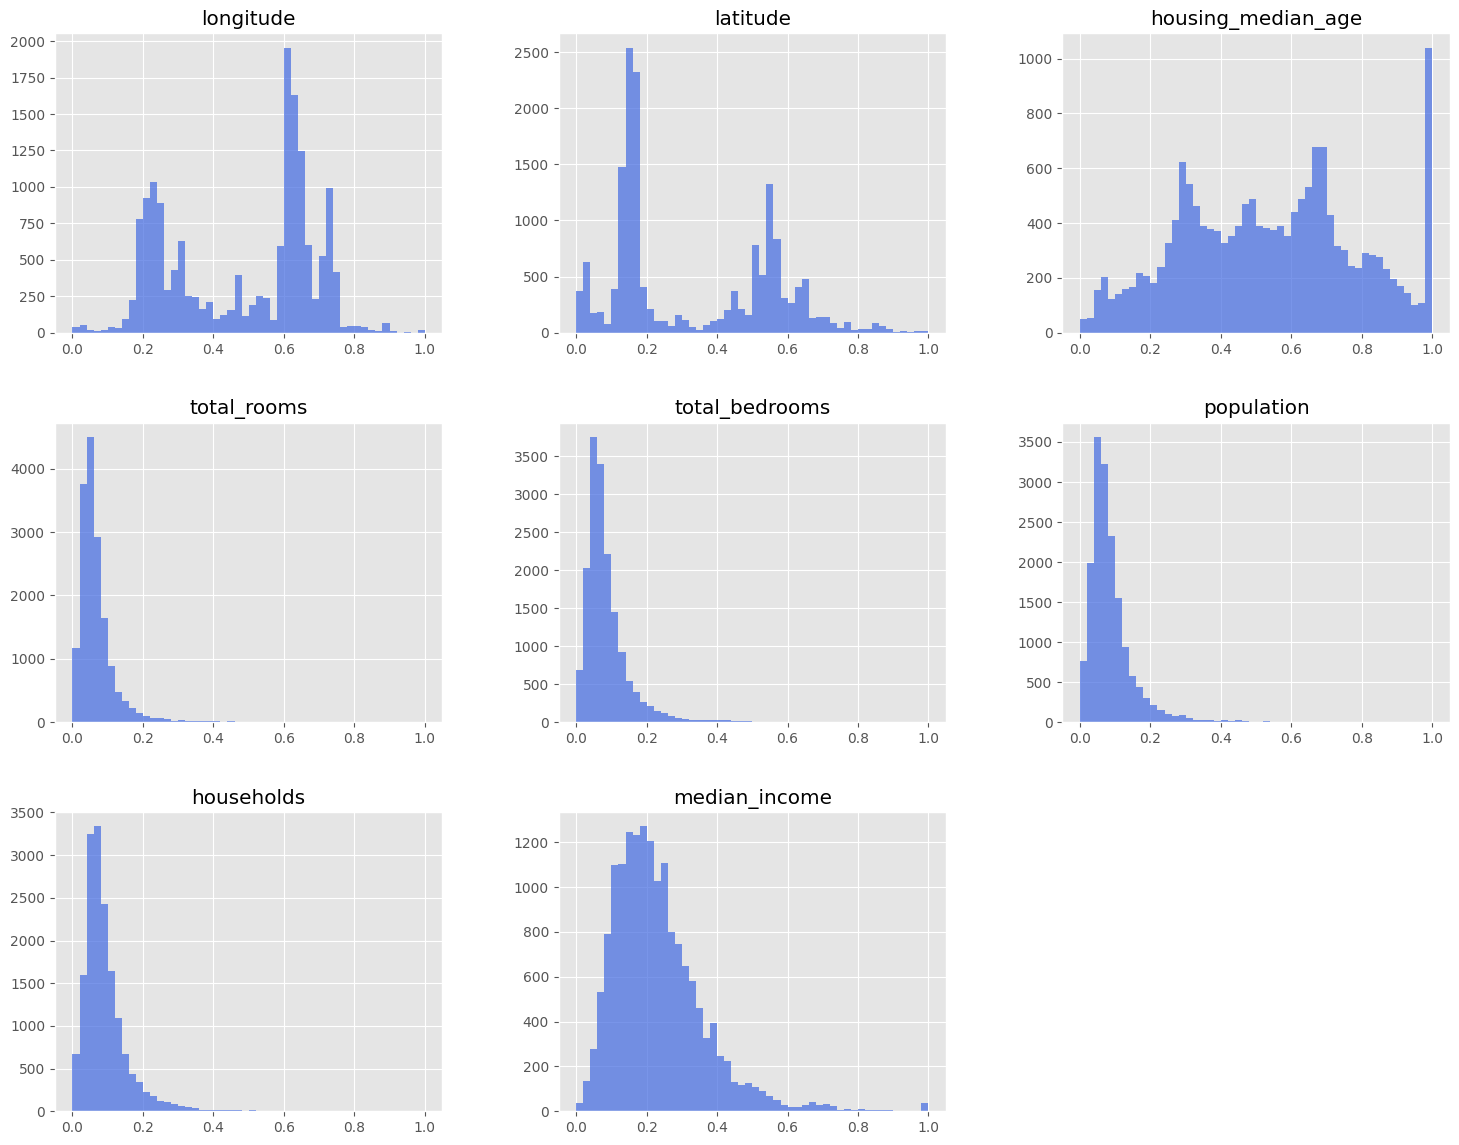

In [33]:
from sklearn.preprocessing import MinMaxScaler

# we create an instance of the MinMaxScaler class
scaler_mm = MinMaxScaler()

# we fit the scaler to the training data
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
scaler_mm.fit(X_encoded[num_attribs])

# we transform the training set
X_scaled = scaler_mm.transform(X_encoded[num_attribs])

# we convert the NumPy array back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X_encoded[num_attribs].columns, index=X_encoded.index)

# merge the dataframes (we replace the original numerical columns with the scaled ones)
X_encoded[num_attribs] = X_scaled

# check the first rows of the data
X_encoded.head()

# show the new distribution of the numerical attributes
X_encoded[num_attribs].hist(bins=50, figsize=(18,14), color='royalblue', alpha=0.7)
plt.show()

#### Standardization

Standardization is a feature scaling technique that transforms data to have a mean of 0 and a standard deviation of 1. It is widely used in machine learning, particularly for algorithms that assume normally distributed data (e.g., linear regression, logistic regression, PCA, and neural networks).

Formula:
$$X^{\prime} = \frac{X - \mu}{\sigma}$$

+ $X$ is the original value,
+ $\mu$ is the mean of the feature,
+ $\sigma$ is the standard deviation of the feature,
+ $X^{\prime}$ is the standardized value.



Agaim, `scikit-learn` provides us with the suitable function: 

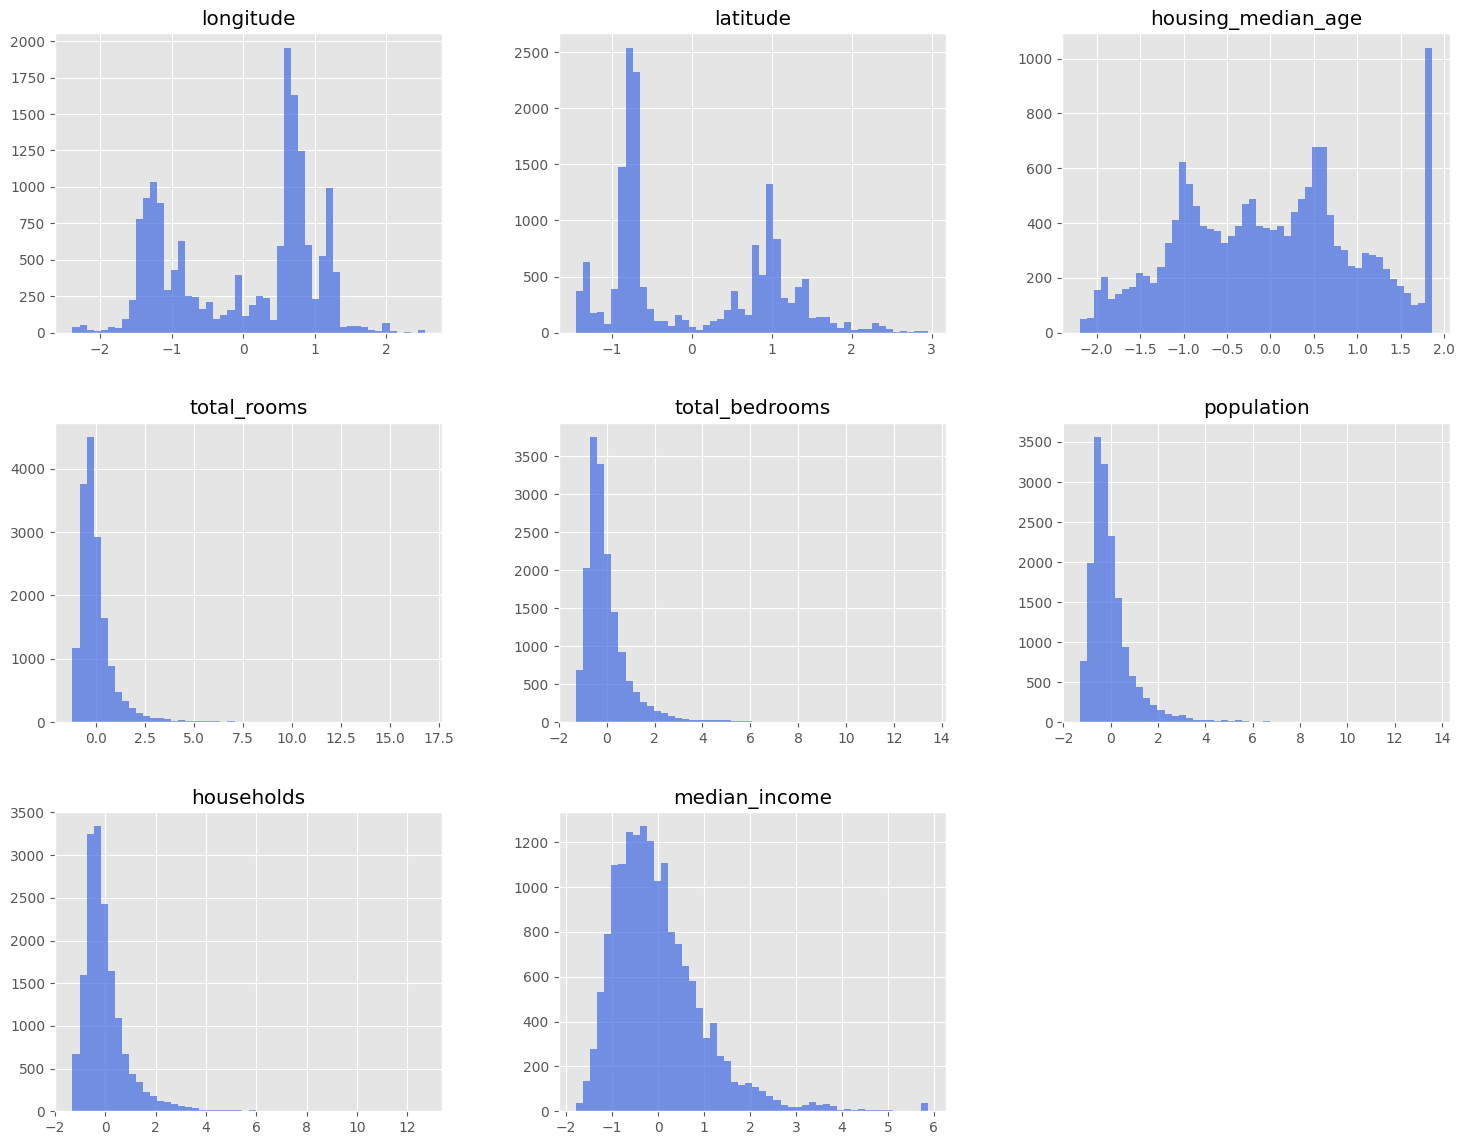

In [34]:
from sklearn.preprocessing import StandardScaler

# we create an instance of the StandardScaler class
scaler_ss = StandardScaler()

# we fit the scaler to the training data
scaler_ss.fit(X_encoded[num_attribs])

# we transform the training set
X_scaled = scaler_ss.transform(X_encoded[num_attribs])

# we convert the NumPy array back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X_encoded[num_attribs].columns, index=X_encoded.index)

# merge the dataframes (we replace the original numerical columns with the scaled ones)
X_encoded[num_attribs] = X_scaled

# check the first rows of the data
X_encoded.head()

# show the new distribution of the numerical attributes
X_encoded[num_attribs].hist(bins=50, figsize=(18,14), color='royalblue', alpha=0.7)
plt.show()

These both approaches are usually very effective to ensure faster convergence. However, when the features have a heavy tail (they are skewed either to the right or to the left), we should reduce this skewness before preprocessing them through `MinMaxScaler()` or `StandardScaler()`. These reasons might justify the fact that we transform our features before the preprocessing: 

1. **Poor Feature Representation** – The transformation will be disproportionately influenced by extreme values (outliers), leading to an ineffective scale.
2. **Loss of Gaussian Assumptions** – Many machine learning algorithms assume normally distributed features. If skewness remains, it can negatively impact model performance.
3. **Reduced Model Convergence** – Highly skewed data may lead to imbalanced learning, affecting optimization processes in gradient-based models (e.g., neural networks, logistic regression).
4. **Incorrect Scaling Effect** – MinMax Scaling and Standardization depend on extreme values $(X_{\max}, X_{\min}$ or $\mu, \sigma)$, and a skewed distribution can make the transformed data less meaningful.


#### Log Transformation

For features with a significant skewness, we can use a **log transformation** since they will not change the **ordinal scale** of our values but they might help to reduce the skewness. 
We will simply transform our features as: 
$$
X^{\prime} = log(X)
$$

First, we recreate our original `X_encoded`:

In [35]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False) # drop='first' to avoid multicollinearity by dropping the first category, sparse_output=False to return a 2D array
encoded_features = encoder.fit_transform(X[['ocean_proximity']]) # Fit and transform the data

# Add encoded features back to the DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['ocean_proximity']), index=X.index)
X_encoded = pd.concat([X.drop(columns=['ocean_proximity']), encoded_df], axis=1)

X_encoded.head(n=6)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   
1286     -121.31     37.96                52.0       1829.0           301.0   

       population  households  median_income  ocean_proximity_INLAND  \
13096      1576.0      1034.0         2.0987                     0.0   
14973       666.0       357.0         6.0876                     0.0   
3785        562.0       203.0         2.4330                     1.0   
14689      1845.0       780.0         2.2618                     1.0   
20507      1912.0      1172.0         3.5292                     0.0   
1286        694.0       319.0         3.3466                     1.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
13096                     0.0                       1.0   
14973                     0.0                       0.0   
3785                      0.0                       0.0   
14689                     0.0                       0.0   
20507                     0.0                       0.0   
1286                      0.0                       0.0   

       ocean_proximity_NEAR OCEAN  
13096                         0.0  
14973                         0.0  
3785                          0.0  
14689                         0.0  
20507                         1.0  
1286                          0.0

Then, we make a copy:

In [36]:
X_transformed = X_encoded.copy()

once this is done, we log-transform the feature `population`  

In [37]:
# the log-transformed X
X_transformed["log_population"] = np.log(X_transformed["population"])
X_transformed["log_total_rooms"] = np.log(X_transformed["total_rooms"])
X_transformed["log_total_bedrooms"] = np.log(X_transformed["total_bedrooms"])
X_transformed["log_households"] = np.log(X_transformed["households"])

# the header of the new DataFrame
X_transformed.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  ocean_proximity_INLAND  \
13096      1576.0      1034.0         2.0987                     0.0   
14973       666.0       357.0         6.0876                     0.0   
3785        562.0       203.0         2.4330                     1.0   
14689      1845.0       780.0         2.2618                     1.0   
20507      1912.0      1172.0         3.5292                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
13096                     0.0                       1.0   
14973                     0.0                       0.0   
3785                      0.0                       0.0   
14689                     0.0                       0.0   
20507                     0.0                       0.0   

       ocean_proximity_NEAR OCEAN  log_population  log_total_rooms  \
13096                         0.0        7.362645         8.108021   
14973                         0.0        6.501290         7.583248   
3785                          0.0        6.331502         6.987490   
14689                         0.0        7.520235         8.336630   
20507                         1.0        7.555905         8.381603   

       log_total_bedrooms  log_households  
13096            7.016610        6.941190  
14973            5.869297        5.877736  
3785             5.379897        5.313206  
14689            6.746412        6.659294  
20507            7.099202        7.066467

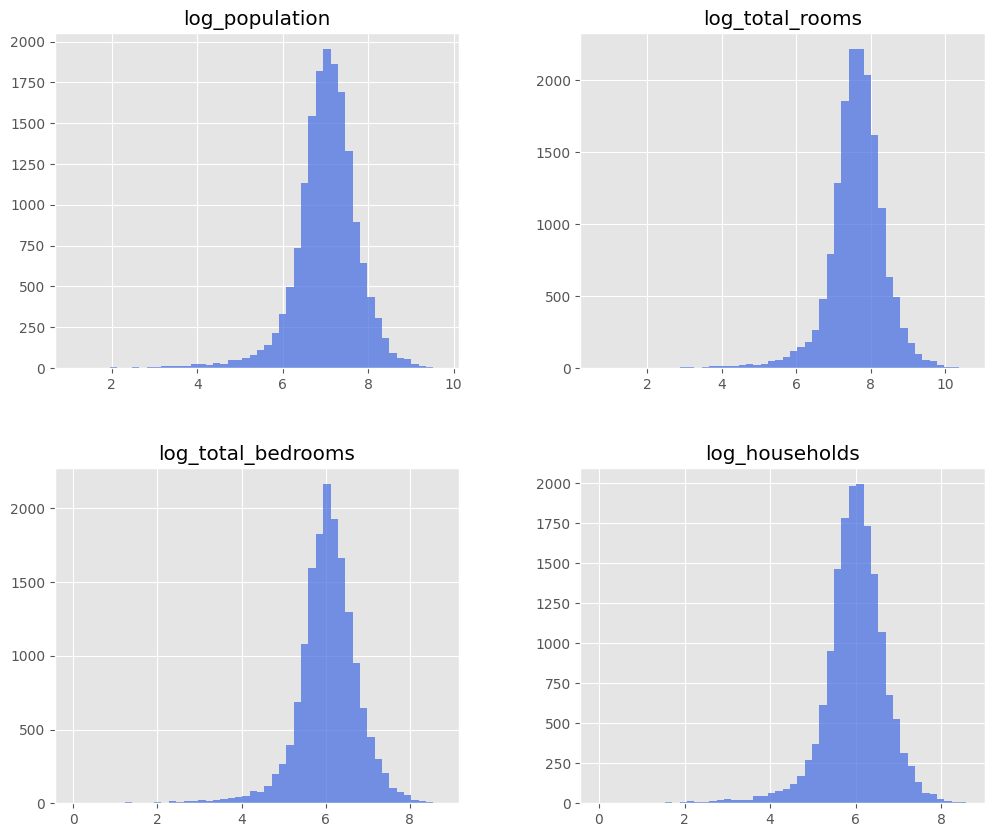

In [38]:
# the histograms of the log-transformed features
X_transformed[["log_population", "log_total_rooms", "log_total_bedrooms", "log_households"]].hist(bins=50, figsize=(12,10), color='royalblue', alpha=0.7)
plt.show()

We see that this method has largely reduced the skewness of our features. However, we did not apply this transformation to every feature. Indeed, for multimodal features such as the `housing_median_age`, we can have recourse to two other different techniques: 

**1. Bucketsizing**

Bucketsizing is a data processing technique where continuous or high-cardinality categorical variables are divided into discrete groups or “buckets” to simplify analysis, improve interpretability, or enhance model performance. A common way to implement bucketsizing is by choosing quantiles. E.g. you split the data into ten categories and you assign them to their respective quantile.

**2. Radial Basis Functions (RBF)**

A Radial Basis Function (RBF) is a function whose value depends only on the distance from a central point. Mathematically, an RBF is defined as:

$$\phi(\mathbf{x}) = \phi(\|\mathbf{x} - \mathbf{c}\|)$$

where:
+ $\mathbf{x}$  is the input vector,
+ $\mathbf{c}$  is the center of the function,
+ $\|\mathbf{x} - \mathbf{c}\|$  represents the Euclidean distance,
+ $\phi$  is the RBF function.

**Gaussian Radial Basis Function (Gaussian RBF)**

A Gaussian RBF is a specific type of RBF defined as:

$$\phi(\mathbf{x}) = e^{- \gamma(\mathbf{x} - \mathbf{c})^2}$$

where:
+ $\gamma$ is a spread parameter that controls the width of the Gaussian function.
+ The function reaches its maximum ( $\phi = 1$ ) at  $\mathbf{x} = \mathbf{c}$  and decreases exponentially as  $\mathbf{x}$  moves away from  $\mathbf{c}$.

**Properties of Gaussian RBF**
1. Localized Influence: The function has a strong impact near the center  $\mathbf{c}$  and diminishes as distance increases.
2. Smoothness: The Gaussian function is infinitely differentiable, making it useful in interpolation and machine learning.
3. Parameter Sensitivity: The choice of  $\gamma$  significantly affects model performance. A small  $\gamma$  results in narrow peaks, while a large  $\gamma$  leads to broader influence.
```

In both of these cases, we are basically separating the data into different clusters. 

We create our function:

In [39]:
def my_rbf(X, c, gamma): 
    return np.exp(-gamma * np.linalg.norm(X - c, axis=1)**2)

For illustrative purposes, we replot the distribution of the feature `housing_median_age`:

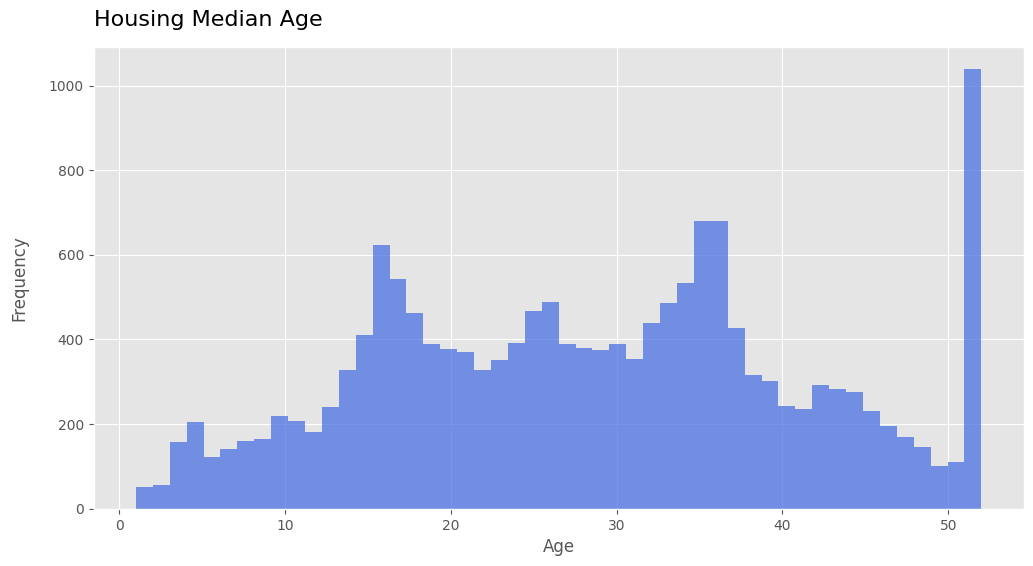

In [40]:
X_transformed['housing_median_age'].hist(bins=50, figsize=(12, 6), color='royalblue', alpha=0.7)
plt.title("Housing Median Age", fontsize=16, loc='left', pad=15)
plt.xlabel("Age")
plt.ylabel("Frequency", labelpad=15)
plt.show()

Now, we visualize the new feature:

In [41]:
ages = np.linspace(X_transformed['housing_median_age'].min(), X_transformed['housing_median_age'].max(), 500)
print(ages.shape)

# we reshape the data to fit the model
ages = ages.reshape(-1, 1)
print(ages.shape)

(500,)
(500, 1)


In [42]:
rbf_ages = my_rbf(ages, c=35, gamma=0.1).reshape(-1, 1)
rbf_ages.shape


(500, 1)

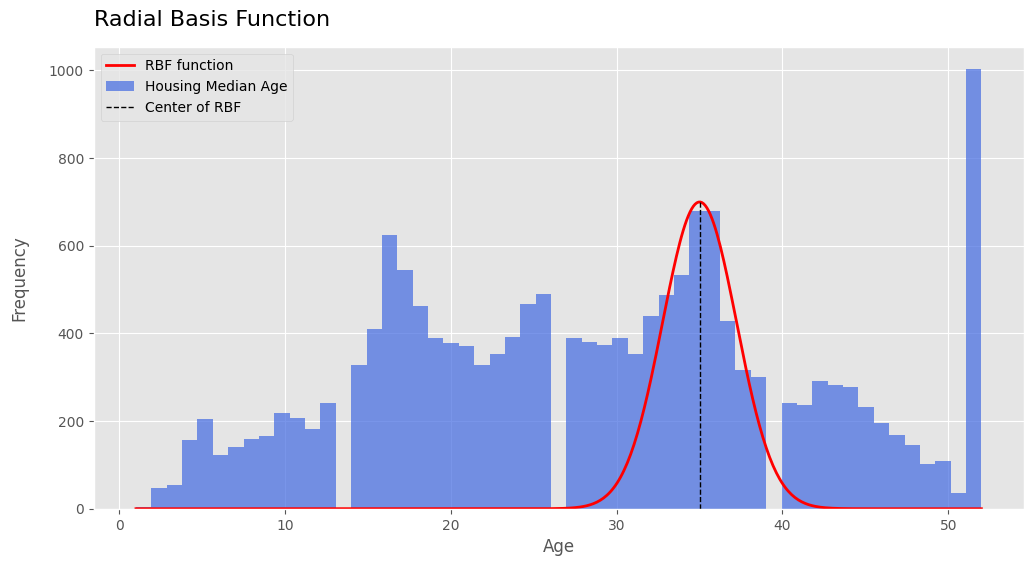

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))

# we plot the RBF function
ax.plot(ages, (rbf_ages * 700), color='red', lw=2, label='RBF function' )

# we plot the housing median age
ax.hist(X_transformed['housing_median_age'], bins=55, color='royalblue', alpha=0.7, label='Housing Median Age')

# center of the RBF
ax.vlines(35, 0, 700, color='black', linestyle='--', lw=1, label='Center of RBF')

ax.set_title("Radial Basis Function", fontsize=16, loc='left', pad=15)
ax.set_xlabel("Age")
ax.set_ylabel("Frequency", labelpad=15)
plt.legend()
plt.show()

In this graph, we are basically attributing weights depending on the similarity of the feature `housing_median_age` with the constant $c=35$ and the hyperparameter $\gamma = 0.1$. The RBF attributes weights of similarity $\theta \in [0, 1]$ but to make things visual we scaled the function by a factor $700$.

Indeed, the RBF can be plotted this way: 

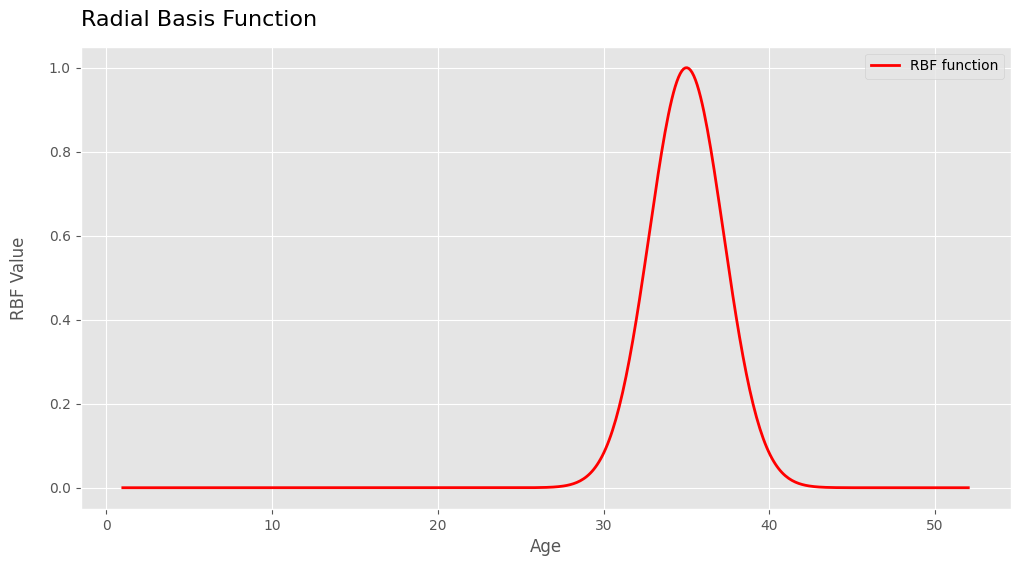

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))

# we plot the RBF function
ax.plot(ages, (rbf_ages), color='red', lw=2, label='RBF function' )

# aesthetics
ax.set_title("Radial Basis Function", fontsize=16, loc='left', pad=15)
ax.set_xlabel("Age")
ax.set_ylabel("RBF Value", labelpad=15)
plt.legend()
plt.show()

Why does this feature could make sense? If low prices are highly correlated with the fact that the house is dated from 35 years, our model will benefit from this new feature. Imagine that 35 years ago, the painter were used to employ a particular chemical in their paint which had noxious aerosol properties. Then, all the houses painted around that period will have a significantly lower selling value. With this narrative this new feature coukd make sense. 

Of course, we can do this for distributions that seem multimodal: 

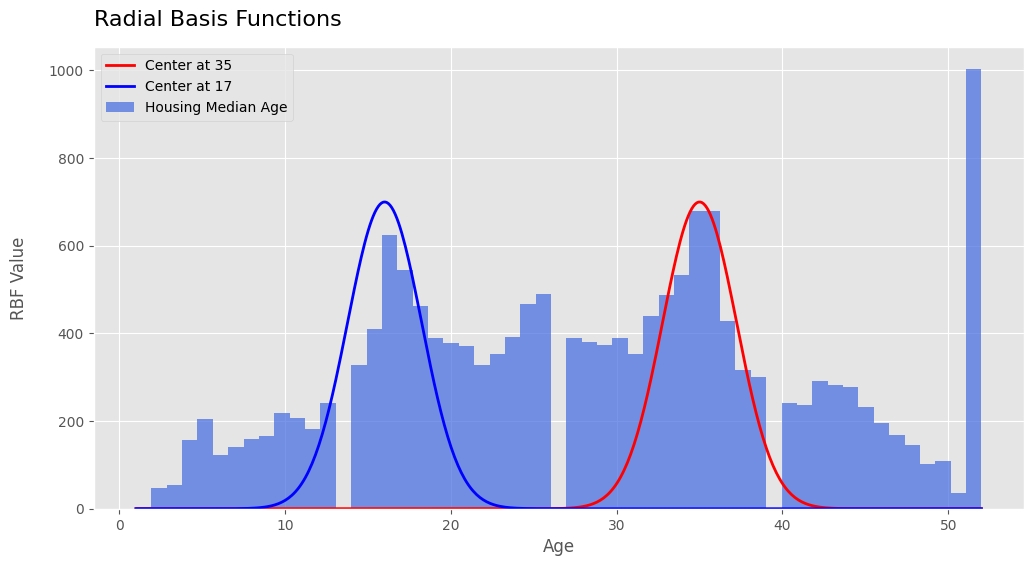

In [45]:
rbf_ages1 = my_rbf(ages, c=35, gamma=0.1).reshape(-1, 1)
rbf_ages2 = my_rbf(ages, c=16, gamma=0.1).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 6))

# we plot the RBF functions
ax.plot(ages, (rbf_ages1)*700, color='red', lw=2, label='Center at 35' )
ax.plot(ages, (rbf_ages2)*700, color='blue', lw=2, label='Center at 17' )

# we plot the housing median age
ax.hist(X_transformed['housing_median_age'], bins=55, color='royalblue', alpha=0.7, label='Housing Median Age')

# aesthetics
ax.set_title("Radial Basis Functions", fontsize=16, loc='left', pad=15)
ax.set_xlabel("Age")
ax.set_ylabel("RBF Value", labelpad=15)
plt.legend()
plt.show()


As usually, `scikit-learn` provides us with a package to do this: 

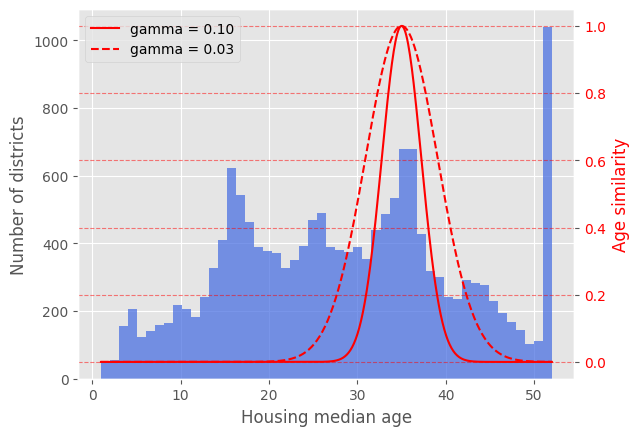

In [46]:
from sklearn.metrics.pairwise import rbf_kernel

ages = np.linspace(X_transformed["housing_median_age"].min(),
                   X_transformed["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(X_transformed["housing_median_age"], bins=50, color="royalblue", alpha=0.7)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "red"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)
ax2.grid(which='both', axis='y', linestyle='--', alpha=0.5, color='red')

plt.legend(loc="upper left")
plt.show()

#### **Custom Transformers**

In [47]:
# we just make a copy of the data
X2 = X_encoded.copy()
X2.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  ocean_proximity_INLAND  \
13096      1576.0      1034.0         2.0987                     0.0   
14973       666.0       357.0         6.0876                     0.0   
3785        562.0       203.0         2.4330                     1.0   
14689      1845.0       780.0         2.2618                     1.0   
20507      1912.0      1172.0         3.5292                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
13096                     0.0                       1.0   
14973                     0.0                       0.0   
3785                      0.0                       0.0   
14689                     0.0                       0.0   
20507                     0.0                       0.0   

       ocean_proximity_NEAR OCEAN  
13096                         0.0  
14973                         0.0  
3785                          0.0  
14689                         0.0  
20507                         1.0

Although `scikit-learn` provides us with many useful transformers, in numerous cases, we will have to build our own ones. For this purpose, `scikit-learn` also provides us with a useful function: `FunctionTransformer()`. We can use it this way to customize our own transformers: 

In [48]:
from sklearn.preprocessing import FunctionTransformer

# we create the log instance: 
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)

# now we could use it to transform the data
X2["log_population"] = log_transformer.fit_transform(X2["population"])

# check the first rows of the data
X2.head()


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  ocean_proximity_INLAND  \
13096      1576.0      1034.0         2.0987                     0.0   
14973       666.0       357.0         6.0876                     0.0   
3785        562.0       203.0         2.4330                     1.0   
14689      1845.0       780.0         2.2618                     1.0   
20507      1912.0      1172.0         3.5292                     0.0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
13096                     0.0                       1.0   
14973                     0.0                       0.0   
3785                      0.0                       0.0   
14689                     0.0                       0.0   
20507                     0.0                       0.0   

       ocean_proximity_NEAR OCEAN  log_population  
13096                         0.0        7.362645  
14973                         0.0        6.501290  
3785                          0.0        6.331502  
14689                         0.0        7.520235  
20507                         1.0        7.555905

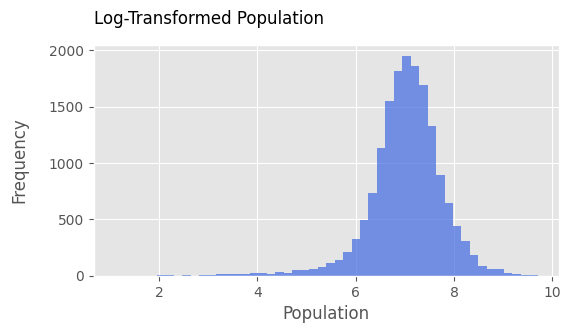

In [49]:
X2["log_population"].hist(bins = 50, figsize=(6, 3), color='royalblue', alpha=0.7)
plt.title("Log-Transformed Population", fontsize=12, loc='left', pad=15)
plt.xlabel("Population")
plt.ylabel("Frequency", labelpad=15)
plt.show()

Of course, you can build much more complicatd transformers and things get a bit more complicated when you need to fit the data before actually transforming them. However, to keep things simple in this first project, we will not cover this part now, it's just good to know that it exists.

#### Transformation Pipelines

A transformation pipeline is a structured sequence of data processing steps, often used in machine learning (ML) and data preprocessing workflows. It helps automate and streamline data transformation, ensuring consistency and efficiency.

Each step in the pipeline applies a specific transformation to the data before passing it to the next step.

                           ┌──────────────────┐
                           │ Raw Data         │
                           └──────────────────┘
                                     │
                                     ▼
                           ┌──────────────────┐
                           │ Data Cleaning    │
                           │ (handle NaNs,    │
                           │ remove outliers) │
                           └──────────────────┘
                                     │
                                     ▼
                           ┌──────────────────┐
                           │ Feature Scaling  │
                           │ (Normalization,  │
                           │ Standardization) │
                           └──────────────────┘
                                     │
                                     ▼
                           ┌──────────────────┐
                           │ Feature Selection│
                           │ (PCA, K-Best)    │
                           └──────────────────┘
                                     │
                                     ▼
                           ┌──────────────────┐
                           │ Model Training   │
                           │ (Regression,     │
                           │ Classification)  │
                           └──────────────────┘
                                     │
                                     ▼
                           ┌──────────────────┐
                           │ Model Evaluation │
                           │ (Accuracy, RMSE) │
                           └──────────────────┘

In this first example, we build a small pipeline that do two things: 
1. Imputation of na numerical values.  
2. Standardization of the features with `StandardScaler()`.

In [50]:
import sklearn
sklearn.set_config(display='diagram')

In [51]:
from sklearn.pipeline import Pipeline

# we create the pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

And if we don't need to name the different steps, we can proceed as follows: 

In [52]:
from sklearn.pipeline import make_pipeline

# we create the pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

**Using the Pipeline**  

Finally, to use the pipeline, you should call the appropriate method depending on the last step of your pipeline. For instance, with our `num_pipeline()`, we can use it this way: 

In [53]:
# we isolate the numerical attributes
X2_num = X2[num_attribs]

# we fit and transform the data
X2_num_pip = num_pipeline.fit_transform(X2_num)
X2_num_pip

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

As we can notice, the output is not a clean dataframe like we wish. Therefore, to recover our dataset, we simply need to use the function `get_feature_names_out()`

In [54]:
X2_num_piped = pd.DataFrame(X2_num_pip, columns=num_pipeline.get_feature_names_out(), index=X2_num.index)

X2_num_piped.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.368167   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.435925   
3785   -1.203098  1.276119            0.351428    -0.712240       -0.760709   
14689   1.231216 -0.884924           -0.919891     0.702262        0.742306   
20507   0.711362 -0.875549            0.589800     0.790125        1.595753   

       population  households  median_income  
13096    0.137460    1.394812      -0.936491  
14973   -0.693771   -0.373485       1.171942  
3785    -0.788768   -0.775727      -0.759789  
14689    0.383175    0.731375      -0.850281  
20507    0.444376    1.755263      -0.180365

Finally, in our case, the most efficient way to proceed would be to process simultaneously the categorical and numerical features. To proceed, we use the `ColumnTransformer()` function like this: 

In [55]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

# we create the num pipeline
num_pip = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# we create the cat pipeline
cat_pip = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse_output=False)
)

# we create the full pipeline
full_pip = ColumnTransformer([ # we need to specify (1) the name of the transformer, (2) the transformer, and (3) the columns to apply the transformer to
    ('num', num_pip, num_attribs),
    ('cat', cat_pip, cat_attribs)
])

full_pip

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['ocean_proximity'])])

We can use it this way: 

In [56]:
# we copy the data
X3 = X.copy()

In [57]:
# we fit and transform the data
X3_array = full_pip.fit_transform(X3)
X3_array

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

In [58]:
X3_piped = pd.DataFrame(X3_array, columns=full_pip.get_feature_names_out(), index=X3.index)
X3_piped.head()

num__longitude  num__latitude  num__housing_median_age  \
13096       -1.423037       1.013606                 1.861119   
14973        0.596394      -0.702103                 0.907630   
3785        -1.203098       1.276119                 0.351428   
14689        1.231216      -0.884924                -0.919891   
20507        0.711362      -0.875549                 0.589800   

       num__total_rooms  num__total_bedrooms  num__population  \
13096          0.311912             1.368167         0.137460   
14973         -0.308620            -0.435925        -0.693771   
3785          -0.712240            -0.760709        -0.788768   
14689          0.702262             0.742306         0.383175   
20507          0.790125             1.595753         0.444376   

       num__households  num__median_income  cat__ocean_proximity_INLAND  \
13096         1.394812           -0.936491                          0.0   
14973        -0.373485            1.171942                          0.0   
3785         -0.775727           -0.759789                          1.0   
14689         0.731375           -0.850281                          1.0   
20507         1.755263           -0.180365                          0.0   

       cat__ocean_proximity_ISLAND  cat__ocean_proximity_NEAR BAY  \
13096                          0.0                            1.0   
14973                          0.0                            0.0   
3785                           0.0                            0.0   
14689                          0.0                            0.0   
20507                          0.0                            0.0   

       cat__ocean_proximity_NEAR OCEAN  
13096                              0.0  
14973                              0.0  
3785                               0.0  
14689                              0.0  
20507                              1.0

Now we see that thanks to our `full_pip()`, we have quickly preprocessed our entire dataset. Notice that the names of the columns have changed a bit depending on the pipeline that was applied. 

### 5.4 Building the Final Pipeline

In this part, we will absorb all the knowledge we uncovered throughout section $5$ to build one big pipeline that preprocess our whole dataset to make it ready for training the models. 

In [59]:
from sklearn.compose import make_column_selector

# first, a function to compute a ratio
def column_ratio(X): 
    return X[:, [0]] / X[:, [1]]

# we create a function to get the names
def ratio_name(function_transformer, features_name_in): 
    return ['ratio']

def ratio_pipeline(): 
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pip = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

num_default_pip = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# we create the cat pipeline
cat_pip = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
)

# now, with all these modules of pipelines, we can create a ColumnTransformer

final_pip = ColumnTransformer([
        ("", 'passthrough', ["longitude", "latitude"]), # we do not apply any transformation to these columns
        ("bedrooms_rate", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pip, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("cat", cat_pip, make_column_selector(dtype_include=object)), # the selector will select all columns with object dtype
        ("num", num_default_pip, ["housing_median_age"])
    ])

final_pip

ColumnTransformer(transformers=[('', 'passthrough', ['longitude', 'latitude']),
                                ('bedrooms_rate',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x138b5a7a0>,
                                                                      func=<function column_ratio at 0x138b5aa20>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_bedroo...
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1397305c0>),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['housing_median_age'])])

In [60]:
# we copy the data
X4 = X.copy()

# we fit and transform the data
X4_array = final_pip.fit_transform(X4)

# we convert the NumPy array back to a DataFrame
X4_piped = pd.DataFrame(X4_array, columns=final_pip.get_feature_names_out(), index=X4.index)

# head of the data
X4_piped.head()

__longitude  __latitude  bedrooms_rate__ratio  rooms_per_house__ratio  \
13096      -122.42       37.80              1.846624               -0.866027   
14973      -118.38       34.14             -0.508121                0.024550   
3785       -121.98       38.36             -0.202155               -0.041193   
14689      -117.11       33.75             -0.149006               -0.034858   
20507      -118.15       33.77              0.963208               -0.666554   

       people_per_house__ratio  log__total_bedrooms  log__total_rooms  \
13096                -0.330204             1.324114          0.637892   
14973                -0.253616            -0.252671         -0.063576   
3785                 -0.051041            -0.925266         -0.859927   
14689                -0.141475             0.952773          0.943475   
20507                -0.306148             1.437622          1.003590   

       log__population  log__households  log__median_income  \
13096         0.456906         1.310369           -1.071522   
14973        -0.711654        -0.142030            1.194712   
3785         -0.941997        -0.913030           -0.756981   
14689         0.670700         0.925373           -0.912253   
20507         0.719093         1.481464            0.034537   

       cat__ocean_proximity_INLAND  cat__ocean_proximity_ISLAND  \
13096                          0.0                          0.0   
14973                          0.0                          0.0   
3785                           1.0                          0.0   
14689                          1.0                          0.0   
20507                          0.0                          0.0   

       cat__ocean_proximity_NEAR BAY  cat__ocean_proximity_NEAR OCEAN  \
13096                            1.0                              0.0   
14973                            0.0                              0.0   
3785                             0.0                              0.0   
14689                            0.0                              0.0   
20507                            0.0                              1.0   

       num__housing_median_age  
13096                 1.861119  
14973                 0.907630  
3785                  0.351428  
14689                -0.919891  
20507                 0.589800

## 6. Select and Train a Model

Now that we have framed the problem, we can focus on training a model on the training set and then evaluating it on the training set. In this section, we will not explain the  mathematics behind the algorithms we use, since it is the focus of the next chapters. Here, the purpose is simply to present how a complete machine learning case looks like. 

### 6.1 Train and Evaluate on the Training Set

In this first instance, we use a linear regression from the package `scikit-learn`.

In [66]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

# we fit the model
lin_reg.fit(X4_piped, y)

# we make predictions
y_pred = lin_reg.predict(X4_piped)

# we observe the first 5 predictions
y_pred[:5].round(2)

array([260051.36, 357897.8 , 125817.09, 110019.21, 298948.55])

Now, to observe how well our model is performing, we will compute the RMSE on our whole dataset: 
$$
RMSE(X, \hat{y}) = \sqrt{\frac{1}{n} \sum_{i = 1}^{n} (\hat{y}^{(i)} - y^{(i)})^2}
$$

In [70]:
# we define our own RMSE function
def my_rmse(y_true, y_pred): 
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

# we compute the RMSE
rmse_linreg = my_rmse(y, y_pred)
print(f"RMSE: {rmse_linreg:.2f}")


RMSE: 70630.22


Here, a RMSE of $70630.22$ indicates that our model is not performing very well and should be improved further. Another way of understanding how far away our predicted values `y_pred` or $\hat{y}^{(i)}$ lie from the true values $y^{(i)}$ is to plot `y` against `y_pred`:

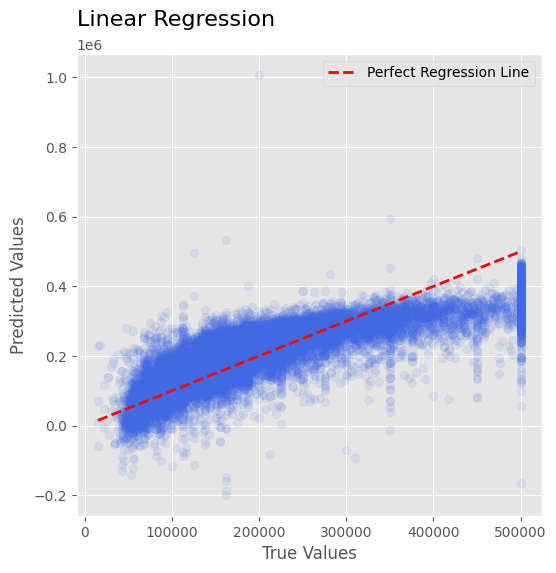

In [86]:
# the basis of the plot: 
fig, ax = plt.subplots(figsize=(6, 6))

# the scatter plot: 
ax.scatter(y, y_pred, color='royalblue', alpha=0.1)

# the perfect regression line
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, linestyle='--', label = 'Perfect Regression Line')

# aesthetics
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
ax.set_title("Linear Regression", fontsize=16, loc='left', pad=20)
plt.legend()

plt.show()


Now, let's try to make predictions with another more complex algorithm, such as `DecisionTreeRegressor()`, another algorithm we will uncover later when talking about ensemble methods. This algorithm hierarchically partitions the $\mathbb{R}^n$ space, where $n$ is the number of features, into local regions (leaf nodes). The prediction for a new input is then formulated as the mean of the target values within the corresponding region.

In [87]:
from sklearn.tree import DecisionTreeRegressor

# we create an instance of the DecisionTreeRegressor class
tree_reg = DecisionTreeRegressor(random_state=42)

# we fit the model
tree_reg.fit(X4_piped, y)

# we make predictions
y_pred_tree = tree_reg.predict(X4_piped)

# we compute the RMSE
rmse_tree = my_rmse(y, y_pred_tree)
print(f"RMSE: {rmse_tree:.2f}")

RMSE: 0.00


#### WHAT? 🤯 Are we really making no mistake? 😲

In this case, we observe a phenomenon that can usually be explained by two main reasons: 
1. Our model is accessing data that should be unforseen (**data leakage**).
2. Our model is **overfitting** the training set.

To evaluate fairly our model, we will use cross-validation, in particular the **$K$-fold** cross validation technique. 

### 6.2 Cross-Validation

Cross-validation is a resampling procedure employed to evaluate machine learning models on a limited data sample. Its primary purpose is to limit problems like overfitting, giving an insight into how the model will generalize to an independent dataset. It's essentially about leveraging different subsets of your data to train and validate the model, ensuring that it gets the opportunity to train on multiple train-validation splits. This offers multiple benefits, including a more robust model performance and a better understanding of the model's variance and bias.

#### Leave-One-Out Cross-Validation (LOOCV)

Leave-One-Out Cross-Validation, often abbreviated as LOOCV, is a particular case of cross-validation where the $K$ (number of data splits) is set to the number of observations in the dataset. In LOOCV, the model is trained on all data points except one, which serves as the test set. This process is iteratively repeated until each data point has had a chance to be the validation set. However, LOOCV can be computationally expensive due to the number of times the model has to be retrained. It is, therefore, mostly practical for smaller datasets.

#### K-Fold Cross-Validation

In K-Fold Cross-Validation, the dataset is randomly partitioned into $K$ equal-sized subsets (or folds). Of these, a single fold is retained as the validation set for model validation, while the remaining K-1 folds are used for training. This process is repeated K times, ensuring each fold gets a turn to serve as the validation set. The results from all $K$ validations are then averaged to produce a single estimation. K-Fold Cross-Validation is particularly beneficial when the dataset size is limited, as it ensures that every data point gets to be in both the training and validation sets, providing a more comprehensive view of the model's performance. Typically, values of $K$ like 5 or 10 are chosen, considering the balance between computational cost and the reliability of the performance estimation.


The `scikit-learn` documentation provides a great visual of cross-validation. The visual is shown below for a 5-fold cross-validation, but the intuition is the same for any value of $K$ (also $K=n$ for LOOCV):

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Here, we use the `KFold()` function to draw the indexes we need to partition our datasets into $K$ folds:

In [94]:
from sklearn.model_selection import KFold
import numpy as np

# we make copy of the data
X_train = X4_piped.copy().to_numpy()
y_train = y.copy().to_numpy()

# Define K-Fold cross-validation (K=8)
kf = KFold(n_splits=8, shuffle=True, random_state=42)

# cross-validation
rmse_values = []

for train_index, test_index in kf.split(X_train):
    X_tr, X_te = X_train[train_index], X_train[test_index]
    y_tr, y_te = y_train[train_index], y_train[test_index]
    
    # we create an instance of the DecisionTreeRegressor class
    tree_reg = DecisionTreeRegressor(random_state=42)
    
    # we fit the model
    tree_reg.fit(X_tr, y_tr)
    
    # we make predictions
    y_pred_tree = tree_reg.predict(X_te)
    
    # we compute the RMSE
    rmse = my_rmse(y_te, y_pred_tree)
    rmse_values.append(rmse)

# we convert the list to a NumPy array
rmse_values = np.array(rmse_values)

# we compute the mean and the standard deviation
mean_rmse = rmse_values.mean()
std_rmse = rmse_values.std()

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Standard deviation RMSE: {std_rmse:.2f}")

Mean RMSE: 70362.94
Standard deviation RMSE: 3122.73


🧠 Understanding `kf.split(X_train)`
+ `kf` is an instance of `KFold(n_splits=8, shuffle=True, random_state=42)`, which is responsible for splitting `X_train` into training and testing sets.
+ `kf.split(X_train)` generates 8 different train-test splits (since `n_splits`$=8$), each time selecting a different subset of the data as the test set, while the remaining data serves as the training set.
+ `kf.split(X_train)` returns an iterator that yields tuples:

Conclusion: We see that once we have used cross-validation, our model isn't so perfect anymore. In fact, on average, it is performing slightly worse than our linear regression.

Now, we try another famous ensemble method, the `RandomForest()`:

In [105]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# we create an instance of the RandomForestRegressor class
forest_reg = RandomForestRegressor(random_state=42, max_features=10)

# we compute the cross-validation scores (this is equivalent to the previous code but more concise), we use the minus sign to get positive values 
scores = - cross_val_score(forest_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=8)

# look at the scores
scores


array([49085.84223615, 49089.5290077 , 47772.95525884, 48806.5379534 ,
       48588.42186831, 49820.79690032, 51263.34800759, 48520.64939981])

In this case, we see that the random forest algorithm seems more promising since we obtain lower RMSE on average: 

In [106]:
round(float(scores.mean()), 2)

49118.51

### 6.3 Fine-tuning the model 

Once we have established a short-list of the most promising models, we should fine-tune their hyperparameters to enhance further the quality of our predictions. To proceed, we will oftentimes have recourse to two powerful function named `GridSearchCV()` or `RandomizedSearchCV()`. To provide an intuition of how these function work, we will make a short example. The goal is to find the best value for the hyperparameters `max_features` and `n_estimators` (these will be explained in chapter 7) of the `RandomForestRegressor`. 

#### RandomizedSearchCV (Scikit-Learn Documentation)

`class sklearn.model_selection.RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)`
Randomized search on hyper parameters.

RandomizedSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

In contrast to GridSearchCV, **not all parameter values are tried out**, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used. It is **highly recommended to use continuous distributions for continuous parameters**.

**n_iter, default=10**  
Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.

In [112]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# we create a pipeline that include the preprocessing steps and the model 
rf_pipe = Pipeline([
    ('final_pip', final_pip),
    ('rf', RandomForestRegressor(random_state=42))
])

# we define the hyperparameters, to span a wide range of values for the hyperparameters
param_distribs = {
        'rf__n_estimators': randint(low=1, high=200),
        'rf__max_features': randint(low=1, high=20),
    }

# we create an instance of the RandomizedSearchCV class
rnd_search = RandomizedSearchCV(rf_pipe, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)

# we fit the model
rnd_search.fit(X, y)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('final_pip',
                                              ColumnTransformer(transformers=[('',
                                                                               'passthrough',
                                                                               ['longitude',
                                                                                'latitude']),
                                                                              ('bedrooms_rate',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x138b5a7a0>,
                                                                                                                    func=<function column_ratio at 0x13...
                                                                                                StandardScaler())]),
                                                                               ['housing_median_age'])])),
                                             ('rf',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'rf__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x10c41e0c0>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x10c41e600>},
                   random_state=42, scoring='neg_root_mean_squared_error')

Explanation of the code: 

##### 1. Setting Up a Pipeline
The code defines a **machine learning pipeline** (`rf_pipe`) that:
1. First applies **data preprocessing** using `final_pip`.
2. Then fits a **Random Forest Regressor** (`RandomForestRegressor`).

##### 2. Defining the Hyperparameter Search Space
The `param_distribs` dictionary specifies the **hyperparameter values to search over**:
- **`rf__n_estimators`**: The number of trees in the forest, randomly chosen between **1 and 200**.
- **`rf__max_features`**: The maximum number of features to consider for each split, randomly chosen between **1 and 20**.

##### 3. Setting Up Randomized Search Cross-Validation
The code creates an instance of `RandomizedSearchCV`, which:
- Uses the **`rf_pipe` pipeline**.
- Searches for the **best combination of hyperparameters** by randomly selecting values from `param_distribs`.
- Runs **10 different hyperparameter combinations** (`n_iter=10`).
- Performs **3-fold cross-validation** (`cv=3`), meaning the dataset is split into **3 parts**, and the model is trained and tested on different portions of the data.
- Evaluates model performance using **Negative Root Mean Squared Error (`scoring='neg_root_mean_squared_error'`)** as the metric.
- Ensures **reproducibility** by setting a **random seed (`random_state=42`)**.

##### 4. Running the Hyperparameter Search
Finally, the model is trained with `rnd_search.fit(X_train, y_train)`, which:
- **Splits the training data** (`X_train`, `y_train`) into different folds.
- **Trains the pipeline** with different **random selections** of hyperparameters.
- **Finds the best combination** based on the **RMSE score**.

### 6.4 Analyzing the Models and Their Errors

This bit of code will indicate the relative importance of each attribute in making the predictions:

In [113]:
final_model = rnd_search.best_estimator_
features_importance = final_model['rf'].feature_importances_
features_importance.round(3)

array([0.074, 0.067, 0.062, 0.055, 0.113, 0.015, 0.016, 0.015, 0.014,
       0.359, 0.161, 0.   , 0.002, 0.004, 0.042])

Now we use the `zip` function that yield tuples until the input is exhausted to get the features attached to these coeff: 

In [115]:
sorted(zip(features_importance, final_model['final_pip'].get_feature_names_out()), reverse=True)

[(np.float64(0.3586912656639629), 'log__median_income'),
 (np.float64(0.16053116588961983), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.11300857183396722), 'people_per_house__ratio'),
 (np.float64(0.07388981051176452), '__longitude'),
 (np.float64(0.06703562972015609), '__latitude'),
 (np.float64(0.06232555309224324), 'bedrooms_rate__ratio'),
 (np.float64(0.055287170254592635), 'rooms_per_house__ratio'),
 (np.float64(0.042381518224438204), 'num__housing_median_age'),
 (np.float64(0.015594841923588286), 'log__total_rooms'),
 (np.float64(0.015415590795608142), 'log__population'),
 (np.float64(0.015346627223246433), 'log__total_bedrooms'),
 (np.float64(0.01417873700540869), 'log__households'),
 (np.float64(0.003919417630299912), 'cat__ocean_proximity_NEAR OCEAN'),
 (np.float64(0.0022312330615428155), 'cat__ocean_proximity_NEAR BAY'),
 (np.float64(0.00016286716956100488), 'cat__ocean_proximity_ISLAND')]

With this information, we could potentially drop the least important features. Indeed, it could improve our model's performances. 

### 6.5 Evaluate the Model on the Test Set

RMSE: 48957.46


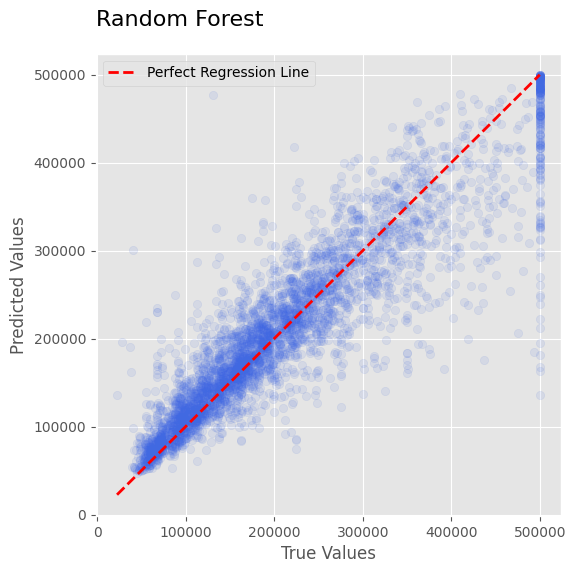

In [121]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# we make predictions
y_pred_final = final_model.predict(X_test)

# we compute the RMSE
rmse_final = my_rmse(y_test, y_pred_final)
print(f"RMSE: {rmse_final:.2f}")

# the basis of the plot:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, y_pred_final, color='royalblue', alpha=0.1)

# the perfect regression line
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--', label = 'Perfect Regression Line')

# aesthetics
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
ax.set_title("Random Forest", fontsize=16, loc='left', pad=20)
plt.legend()
plt.show()

Note: Now the real challenge is to get this into production and ensure that the model's performances don't decay too fast. 

___
# END